# Setup

In [22]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [23]:
%matplotlib inline

In [24]:
from relaxed.plot_defaults import *

In [75]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [65]:
from relaxed.analysis import draw_histogram, get_quantiles, gaussian_conditional, \
get_bins, setup, get_am, get_a2, get_lam

# Data

In [82]:
# catalog
hcat, indices, scales = setup('m11', path='../../temp')
cvir = hcat.cat['cvir']

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../temp')
a2 = get_a2(am, mass_bins)

# throw away last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]
print(am.shape)

/home/imendoza/miniconda3/envs/alcca/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


(9999, 98)


In [83]:
keep, lam, cvir, a2 = get_lam(am, cvir, a2) # remove nan's from lam along the way, like ~600 haloes.

In [84]:
lam_train, lam_test, cvir_train, cvir_test, a2_train, a2_test = train_test_split(lam, cvir, a2, test_size=0.3)

# Train

In [139]:
# multivariate prediction
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(np.log(cvir_train), lam_train)
def gauss(lam_test):
    return np.exp(mu_cond(lam_test))

# lognormal samples 
mu, sigma = np.mean(np.log(cvir_train)), np.std(np.log(cvir_train))
def lognormal(lam_test): 
    n_test = lam_test.shape[0]
    log_cvir_pred = np.random.normal(mu, sigma, n_test)
    return np.exp(log_cvir_pred)


# rank approach
from scipy.interpolate import interp1d
m_cvir = get_quantiles(cvir_train)
m_a2 = get_quantiles(a2_train)

# create interpolations and final function.
f = interp1d(a2_train, m_a2, bounds_error=False, fill_value=np.nan)

bins = np.linspace(cvir_train.min(), cvir_train.max(), 100)
counts = [ sum(cvir_train < bins[i]) / len(cvir_train) for i in range(100)]
g_inv = interp1d(counts, bins, bounds_error=False, fill_value=np.nan)
# g_inv = interp1d(m_cvir, cvir_train, bounds_error=False, fill_value=np.nan)

def cam(lam_test):
    a2_test = get_a2(np.exp(lam_test), mass_bins)
    return g_inv(f(a2_test))

# Plots

In [149]:
# funcs are trained functions that take in lam_test and return cvir_pred, colors are color for each function.
def combined_histogram(lam_test, X_test, *funcs, colors=('r', 'b', 'g'), labels=('1', '2', '3')):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    bins = None
    correlations = []
    for i, f in enumerate(funcs):
        X_pred = f(lam_test)
        x = (X_pred - X_test) / X_test
        if bins is None: 
            bins = get_bins(x) # share bins between all histograms.
        draw_histogram(ax, x, vline=None, legend_label=labels[i], color=colors[i], 
                       bins=bins, density=False)
        
        print(f'{labels[i]} corr: {scipy.stats.spearmanr(X_pred, X_test)[0]}')
        
    
    ax.legend()

multi-normal corr: 0.7551375282497231
lognormal corr: -0.027539775681365685
CAM corr: -0.6810956541648471


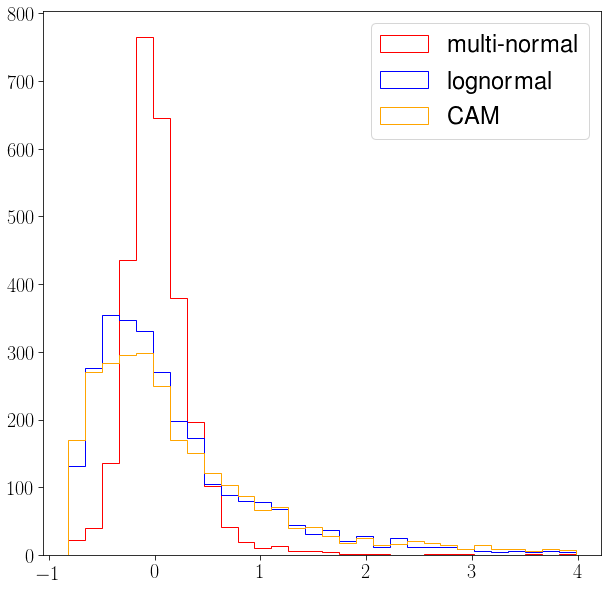

In [150]:
labels = ['multi-normal', 'lognormal', 'CAM']
colors = ['r', 'b', 'orange']
combined_histogram(lam_test, cvir_test, gauss, lognormal, cam, labels=labels, colors=colors)

In [145]:
scipy.stats.spearmanr(a2_test, cvir_test)

SpearmanrResult(correlation=-0.6810956541648471, pvalue=0.0)

In [146]:
scipy.stats.spearmanr(cam(lam_test), cvir_test)

SpearmanrResult(correlation=-0.6810956541648471, pvalue=0.0)

## Combined Histogram

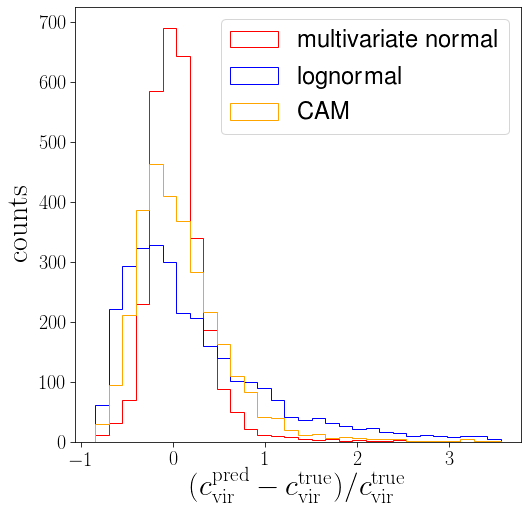

In [15]:
fig, ax = plt.subplots(1,1,figsize=(8,8))


# use gaussian multivariate conditional
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(np.log(cvir_train), lam_train)
assert callable(mu_cond)
log_cvir_pred = mu_cond(lam_test)
cvir_pred = np.exp(log_cvir_pred)
x = (cvir_pred - cvir_test) / cvir_test

bins = get_bins(x)

draw_histogram(ax, x, vline=None, legend_label='multivariate normal', color='r', bins=bins, density=False)


# sampling from lognormal with mean/var equal to true distribution.
log_cvir_pred = np.random.normal(np.mean(np.log(cvir_train)), np.std(np.log(cvir_train)), 3000)
cvir_pred = np.exp(log_cvir_pred)
x = (cvir_pred - cvir_test) / cvir_test
draw_histogram(ax, x, vline=None, legend_label='lognormal', color='b', bins=bins, density=False)


# Rank of a_1/2 approach.
idx = np.where((0.498 < mass_bins) & (mass_bins < 0.51) )[0].item()
a_2 = am[:, idx]


sort_train = np.argsort(a_2[train_indices])
sort_test = np.argsort(a_2[test_indices])

a_2_train = a_2[train_indices][sort_train]
a_2_test = a_2[test_indices][sort_test]

_cvir_train = cvir[train_indices][sort_train]
_cvir_test = cvir[test_indices][sort_test]

# where do we need to insert each id in sub_pids to keep host_ids ordered.
sorted_idx = np.searchsorted(a_2_train, a_2_test)

#for the ones that are bigger than everything, just default to the upper bound
sorted_idx[sorted_idx >= len(a_2_train)] = len(a_2_train) - 1

#just take the corresponding cvir as pred. 
_cvir_pred = _cvir_train[sorted_idx]
x = (_cvir_pred - _cvir_test) / _cvir_test
draw_histogram(ax, x, vline=None, legend_label=r'CAM', color='orange', bins=bins, density=False)


ax.set_xlabel(r"$(c_{\rm vir}^{\rm pred} - c_{\rm vir}^{\rm true})/ c_{\rm vir}^{\rm true}$", size=30)
ax.set_ylabel(r"\rm counts", size=30)

ax.legend()
plt.show()